# Задание 2. Расчет показателя VAR и реализация процедуры бэк-тестинга 

## Цель задания:
### 1. Провести статистический анализ финансового актива и сделать выводы о его распределении
### 2. Рассчитать показатели VAR и ES историческим и параметрическим методами 
### 3. Провести процедуру бэк-тестинга показателя VAR
### 4. Рассчитать показатель портфельного VAR
### Для выполнения данного задания целесообразно ознакомиться с материалом, содержащимся в файле "Var_methods.pdf"

## 1.Загрузка библиотек

In [115]:
import numpy as np
import pandas as pd
from scipy import stats

In [116]:
from __future__ import division

In [117]:
from os import listdir

In [118]:
from os.path import isfile,join # функции, необходимые для работы с файлами и директориями

In [119]:
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 

In [120]:
import seaborn as sns # графическая библиотека

In [121]:
## 2.Загрузка данных и их преобразование в необходимый формат

In [122]:
Tickers=['AAPL','JNJ','BAC','NKE']# выбранные для анализа активы

In [123]:
path='/home/maxime/Documentos/Derivatives/VAR'

In [124]:
files=[f for f in listdir(path) if (isfile(join(path,f))&(f.endswith('csv')))] 
# создание списка имен файлов 

In [125]:
# создание массива, содержащего даты и цены закрытия для каждого актива
df_list=[]
for f in files:
    fname=join(path,f)
    print fname
    df=pd.read_csv(fname,usecols=['Date','Close'],parse_dates=['Date'])
    new_col_name=f[0:(len(f)-4)]
    df.rename(columns={'Close':new_col_name},inplace=True)
    df_list.append(df)

/home/maxime/Documentos/Derivatives/VAR/NKE.csv
/home/maxime/Documentos/Derivatives/VAR/BAC.csv
/home/maxime/Documentos/Derivatives/VAR/AAPL.csv
/home/maxime/Documentos/Derivatives/VAR/JNJ.csv


In [126]:
port=reduce(lambda left,right: pd.merge(left,right,on=['Date']),df_list)
# объединение активов в один массив (dataframe)

In [127]:
port.tail()

,Date,NKE,BAC,AAPL,JNJ
1227,2019-01-02,74.059998,24.959999,157.919998,127.750000
1228,2019-01-03,72.750000,24.559999,142.190002,125.720001
1229,2019-01-04,74.650002,25.580000,148.259995,127.830002
1230,2019-01-07,75.720001,25.559999,147.929993,127.010002
1231,2019-01-08,76.730003,25.510000,150.750000,129.960007


In [128]:
port_log=port.iloc[:,1:]

In [129]:
port_log=port_log.apply(lambda x:np.log(x)-np.log(x).shift(1))
### расчет логарифмической доходности для каждого актива

In [130]:
port_log=port_log.iloc[1:,:]

In [131]:
port_log.tail()

,NKE,BAC,AAPL,JNJ
1227,-0.001080,0.012903,0.001140,-0.010125
1228,-0.017847,-0.016155,-0.104924,-0.016018
1229,0.025782,0.040692,0.041803,0.016644
1230,0.014232,-0.000782,-0.002228,-0.006435
1231,0.013250,-0.001958,0.018884,0.022961


### Для дальнейшего анализа выберем акции компании Apple(первые 500 торговых дней)

In [132]:
data=port_log['AAPL'][:500]

In [133]:
## 3.Анализ распредления доходности финансового актива

In [134]:
data.describe() # описательная статистика

count    500.000000
mean       0.000367
std        0.015693
min       -0.067965
25%       -0.007355
50%       -0.000029
75%        0.009505
max        0.078794
Name: AAPL, dtype: float64

In [135]:
stats.skew(data)# коэффициент асимметрии

-9.896264799660443e-06

In [136]:
stats.kurtosis(data)# эксцесс

2.90929357731721

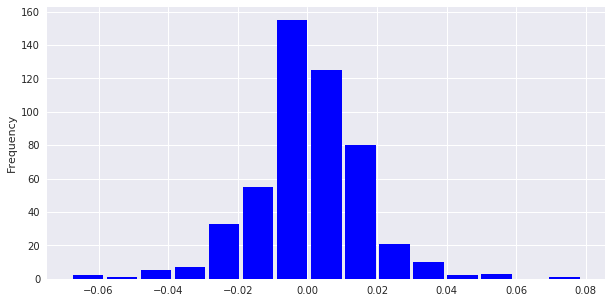

In [137]:
data.plot(kind='hist',grid=True, bins=15, rwidth=0.9,
                   color='blue',figsize=(10,5))

/home/maxime/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


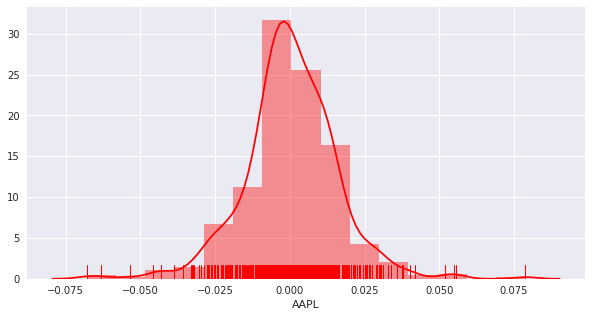

In [138]:
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(data,bins=15,rug=True,color='red');

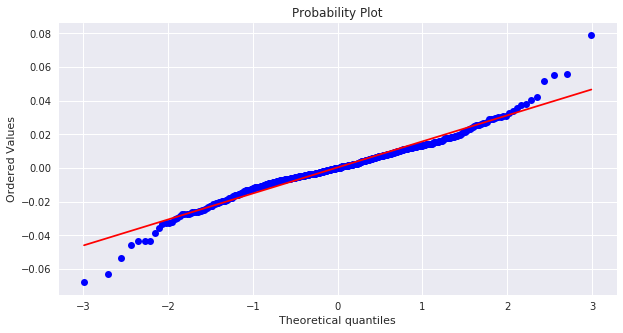

In [139]:
fig = plt.figure(figsize=(10,5))
stats.probplot(data, dist="norm",plot=plt)
plt.show()

In [140]:
stats.normaltest(data)# тест Д'Агостино (основан на значениях эксцесса и ассиметрии )

NormaltestResult(statistic=39.214639900203061, pvalue=3.0524540902634347e-09)

## Основные выводы: Значение теста говорит о том, что  распределение анализируемого актива отличается от нормального закона. При этом отметим, что гистограмма распределения визуально достаточно близка к нормальному закону.

## 4.Функции для расчета VAR 

### Исторический VAR

In [141]:
def VAR_hist(data,alpha=0.05):
    return (np.percentile(data,alpha*100))

### Параметрический нормальный VAR

### $VAR=\mu+z_\alpha\sigma$

In [142]:
def VAR_normal(data,alpha=0.05,t=1):
    return np.mean(data)*t+stats.norm.ppf(alpha)*np.std(data)*t**.5               

### Параметрический нормальный модифицированный VAR

### Расчет скорректированного значения $z_\alpha$

###  $z_\alpha(corrected)=z_\alpha+\frac{1}{6}\left({z_\alpha}^2-1\right)S+\frac{1}{24}\left({z_\alpha}^3-3z_\alpha\right)K-\frac{1}{36}\left({2z_\alpha}^3-5z_\alpha\right)S^2$

In [143]:
def z_corrected(data,alpha=0.05,t=1):
    return (stats.norm.ppf(alpha)+1/6*(stats.norm.ppf(alpha)**2-1)*(1/t**.5)*stats.skew(data)
                             +1/24*(stats.norm.ppf(alpha)**3-3*stats.norm.ppf(alpha))*(1/t)*stats.kurtosis(data)
                                    -1/36*(2*stats.norm.ppf(alpha)**3-5*stats.norm.ppf(alpha))*(1/t)*
                                    stats.skew(data)**2)

In [144]:
def VAR_normal_modified(data,alpha=0.05,t=1):
    return np.mean(data)*t+z_corrected(data,alpha,t)*np.std(data)*t**.5  

### Student VAR

### $VAR=\mu+\sqrt{\frac{\nu-2}{\nu}}\sigma t_{\alpha,\nu}$

### Подбор параметров t-распределения 

In [145]:
df=stats.t.fit(port_log['AAPL'])[0]
df

3.1372764942837161

### Подбор параметров распределения необходим прежде всего для нахождения числа степеней свободы (первое число в скобках)

In [146]:
def VAR_t(data,alpha=0.05,t=1):
    df=stats.t.fit(data)[0]
    return data.mean()*t+stats.t.ppf(alpha,df)*(((df-2)/df)*t)**.5*np.std(data) 

In [147]:
## 4.Расчет VAR 

$\alpha=0.05$

In [148]:
pd.DataFrame([['Historical',VAR_hist(data),'-'],['Normal',VAR_normal(data),VAR_normal(data,t=10)],
                   ['Normal_modified',VAR_normal_modified(data),VAR_normal_modified(data,t=10)],
                   ['Student',VAR_t(data),VAR_t(data,t=10)]],columns=['Method','1day','10days'])

,Method,1day,10days
0,Historical,-0.025405,-
1,Normal,-0.025420,-0.0778778
2,Normal_modified,-0.024500,-0.0775868
3,Student,-0.023404,-0.0715009


### Пример интерпретации VAR (нормальный VAR): c вероятностью 5% однодневные убытки составят 2.5% и более от величины позиции

$\alpha=0.01$

In [149]:
pd.DataFrame([['Historical',VAR_hist(data,alpha=.01),'-'],['Normal',VAR_normal(data,alpha=.01),VAR_normal(data,alpha=.01,t=10)],
                   ['Normal_modified',VAR_normal_modified(data,alpha=.01),VAR_normal_modified(data,alpha=.01,t=10)],
                   ['Student',VAR_t(data,alpha=.01),VAR_t(data,t=10,alpha=.01)]],columns=['Method','1day','10days'])

,Method,1day,10days
0,Historical,-0.043125,-
1,Normal,-0.036104,-0.111664
2,Normal_modified,-0.046768,-0.115036
3,Student,-0.041104,-0.127473


## 5.Реализация процедуры бэк-тестинга VAR 

### Процедура бэк-тестинга реализуется посредством скользящего окна. Это значит, что VAR пересчитывается каждый день на основе выборки, равной величине окна. Текущее значение доходности сравнивается с предыдущим значением VAR. В случае, если значение доходности падает ниже значения VAR, число превышений (по модулю) увеличивается на единицу. Далее с помощью статистических тестов проверяется гипотеза о том, в какой степени используемый метод расчета VAR адекватен рассматриваемому процессу. Для проверки гипотезы используется $\chi^2$ - распределения.

### Тест Купиеца

### $LR_{uc}=-2ln[\left(1-p\right)^{T-N}p^N]+2ln{[1-(N/T)]^{T-N}(N/T)^N}$

In [150]:
def LR_uc(T,N,alpha):
    return (-2*np.log((1-alpha)**(T-N)*alpha**N)+2*np.log((1-N/T)**(T-N)*(N/T)**(N)))

### Тест Кристоферссона

### $LR_{ind}=-2ln[(1-\pi)^{\left(T_{00}+T_{10}\right)}\pi^{\left(T_{01}+T_{11}\right)}]+2ln[(1-π_0)^{T_{00}}π_0^{T_{01}}(1-π_1)^{T_{10}}π_1^{T_{11}}]$

In [151]:
def LR_ind(exceed):
    T_11=0
    T_10=0
    T_00=0
    T_01=0
    for i in range(1,len(exceed)):
        #print(exceed[i-1],exceed[i])
        if ((exceed[i-1]==True)&(exceed[i]==True)):
            T_11+=1
        elif((exceed[i-1]==True)&(exceed[i]==False)):
            T_10+=1
        elif((exceed[i-1]==False)&(exceed[i]==False)):
            T_00+=1
        elif((exceed[i-1]==False)&(exceed[i]==True)):
            T_01+=1
    p_0=T_01/(T_00+T_01)
    p_1=T_11/(T_10+T_11)
    p=(T_01+T_11) /(T_00+T_01+T_10+T_11)
    print(T_11,T_01,T_00,T_10)
    return (-2*np.log((1-p)**(T_00+T_10)*p**(T_01+T_11))+2*np.log((1-p_0)**(T_00)*p_0**T_01*(1-p_1)**(T_10)*p_1**T_11))        

In [152]:
window=250 # установим величину скользящего окна

### Процедура бэк-тестинга реализуется сразу для всех рассматриваемых методов. Выполнение процедуры может занять некоторое время.

In [153]:
f_list=[VAR_hist,VAR_normal,VAR_normal_modified,VAR_t]
#  список функций, используемых для рачета VAR

In [154]:
T=len(port_log['AAPL'][window:])

In [155]:
# Критические значение хи-квадрат критерия (уровень значимости - 0.05, ч.с.с.-1)
chi2=stats.chi2.ppf(0.95,1)
chi2

3.841458820694124

### VAR 5%

In [156]:
VAR_5_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x),raw=True)[window-1:-1]) for f in f_list]
# расчет VAR методом скользящего окна для каждого метода

In [157]:
List_exceed_5=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_5_backtest]
# проверка превышения (по модулю) доходности значения VAR по каждому торговому дню

In [158]:
Number_exceed_5=[sum(l) for l in List_exceed_5]
# число превышений 

In [159]:
List_LR_uc_5=[LR_uc(T,N,0.05) for N in Number_exceed_5]
# тест Купиеца

In [160]:
List_LR_ind_5=[LR_ind(l) for l in List_exceed_5]
# тест Кристоферссона

(10, 59, 852, 59)
(10, 54, 862, 54)
(11, 60, 849, 60)
(12, 67, 834, 67)


In [161]:
0.05*len(port_log['AAPL'][window:])
# число превышений исходя из значения $\alpha$

49.050000000000004

In [162]:
Method=['Historical','Normal','Normal_modified','Student']

In [163]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_5,'LR_uc':List_LR_uc_5,'Pass_LR_uc':(List_LR_uc_5<chi2),'LR_ind':List_LR_ind_5
             ,'Pass_LR_ind':(List_LR_ind_5<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,69,7.624897,False,5.033308,False
1,Normal,64,4.394606,False,7.017353,False
2,Normal_modified,71,9.138327,False,6.124082,False
3,Student,79,16.376992,False,4.877267,False


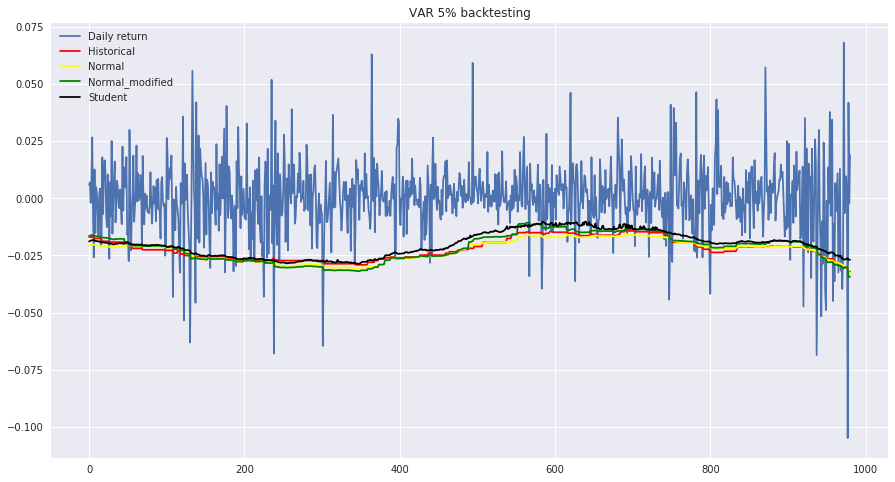

In [164]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_5_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 5% backtesting')
    plt.legend()

### Выводы: Ни один методы расчета VAR не прошел тест Купиеца. Тест на независмость превышений (тест Кристоферссона) не прошел ни один метод.

### VAR 1%

In [166]:
VAR_1_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x,alpha=0.01),raw=True)[window-1:-1]) for f in f_list]

In [167]:
List_exceed_1=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_1_backtest]

In [168]:
Number_exceed_1=[sum(l) for l in List_exceed_1]

In [169]:
List_LR_uc_1=[LR_uc(T,N,0.01) for N in Number_exceed_1]

In [170]:
List_LR_ind_1=[LR_ind(l) for l in List_exceed_1 ]

(0, 16, 948, 16)
(2, 22, 934, 22)
(0, 16, 948, 16)
(1, 17, 945, 17)


In [171]:
0.01*len(port_log['AAPL'][window:])
# число превышений исходя из значения $\alpha$

9.81

In [172]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_1,'LR_uc':List_LR_uc_1,'Pass_LR_uc':(List_LR_uc_1<chi2),'LR_ind':List_LR_ind_1
             ,'Pass_LR_ind':(List_LR_ind_1<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,16,3.313503,True,0.531145,True
1,Normal,24,14.771621,False,2.249924,True
2,Normal_modified,16,3.313503,True,0.531145,True
3,Student,18,5.540162,False,0.926688,True


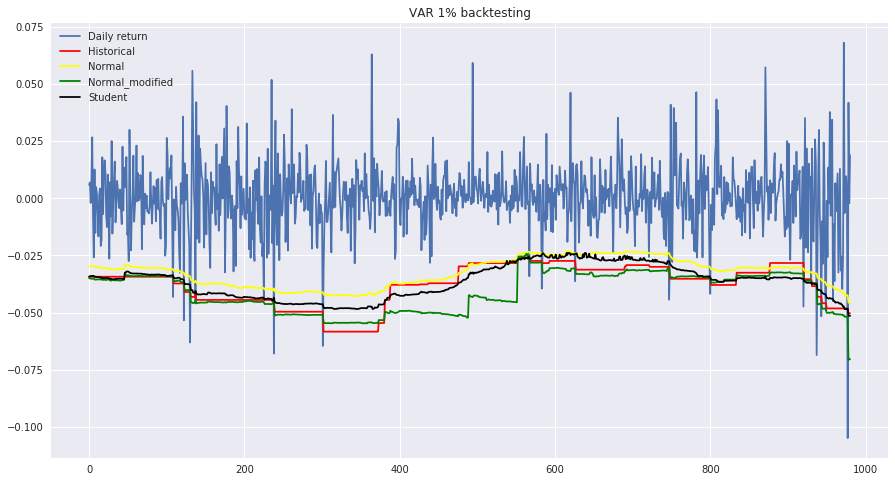

In [173]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_1_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 1% backtesting')
    plt.legend()

### Выводы: Исторический,  модифицированный  методы расчета VAR прошли тест Купиеца. Тест на независмость превышений (тест Кристоферссона)  прошли все методы. Необходимо обратить внимание на то, что чем дальше мы "продвигаемся" по левому хвосту рапсределения, тем менее точным становится оценка VAR на основе нормального распределения.

### VAR 0.1%

In [174]:
VAR_01_backtest=[list(port_log['AAPL'].rolling(window).apply(lambda x:f(x,alpha=0.001),raw=True)[window-1:-1]) for f in f_list]

In [175]:
List_exceed_01=[list(port_log['AAPL'][window:]<list(l)) for l in VAR_01_backtest]

In [176]:
Number_exceed_01=[sum(l) for l in List_exceed_01]

In [177]:
List_LR_uc_01=[LR_uc(T,N,0.001) for N in Number_exceed_01]

In [178]:
List_LR_ind_01=[LR_ind(l) for l in List_exceed_1 ]

(0, 16, 948, 16)
(2, 22, 934, 22)
(0, 16, 948, 16)
(1, 17, 945, 17)


In [179]:
pd.DataFrame({'Method':Method,'N_exceed':Number_exceed_01,'LR_uc':List_LR_uc_01,'Pass_LR_uc':(List_LR_uc_01<chi2),'LR_ind':List_LR_ind_01
             ,'Pass_LR_ind':(List_LR_ind_01<chi2)},columns=['Method','N_exceed','LR_uc','Pass_LR_uc','LR_ind','Pass_LR_ind'])

,Method,N_exceed,LR_uc,Pass_LR_uc,LR_ind,Pass_LR_ind
0,Historical,10,28.480615,False,0.531145,True
1,Normal,14,48.566445,False,2.249924,True
2,Normal_modified,2,0.812380,True,0.531145,True
3,Student,2,0.812380,True,0.926688,True


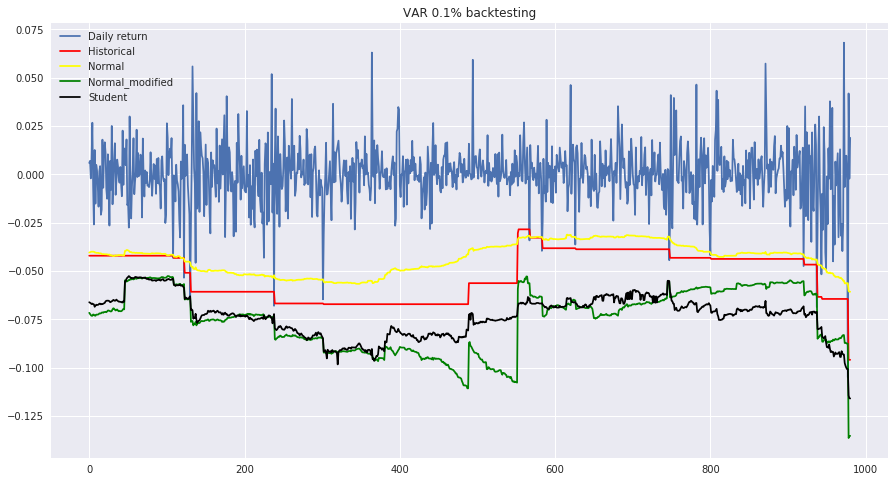

In [180]:
plt.figure(figsize=(15,8))
plt.plot(list(port_log['AAPL'][window:]),label='Daily return')
colors=['red','yellow','green','black']
methods=['']
for i in range(0,4):
    plt.plot(VAR_01_backtest[i],color=colors[i],label=Method[i])
    plt.title('VAR 0.1% backtesting')
    plt.legend()

### Выводы: Модифицированный, t-распределение методы расчета VAR прошли тест Купиеца. Тест на независмость превышений (тест Кристоферссона)  прошли все методы. Необходимо обратить внимание на то, что чем дальше мы "продвигаемся" по левому хвосту рапсределения, тем менее точным становится оценка VAR на основе нормального распределения.

## 6.Расчет Expected shortfall

$\alpha=0.05$

In [181]:
var=VAR_hist(data)

In [182]:
# исторический ES
ES_hist_05=np.mean(data[data<var])
ES_hist_05

-0.035735427470334605

In [183]:
alpha=0.05

### Для вычисления параметрического ES используются параметры выбрнного распределения. Ниже приведена формула ES для нормального распределения.

### $ES=-\sigma\frac{exp\left(-\frac{z_\alpha^2}{2}\right)}{\alpha\sqrt{2\pi}}$

In [184]:
z_alpha=stats.norm.ppf(alpha)# процентная точка нормального распределения

In [185]:
# параметрический VAR
ES_norm_05=-np.std(data)*(np.exp(-(z_alpha**2/2)))/(alpha*np.sqrt(2*np.pi))
ES_norm_05

-0.032338071933906906

$\alpha=0.01$

In [186]:
var=VAR_hist(data,.01)

In [187]:
# исторический ES
ES_hist_01=np.mean(data[data<var])
ES_hist_01

-0.05469206199671941

In [188]:
alpha=0.01

In [189]:
z_alpha=stats.norm.ppf(alpha)

In [190]:
# параметрический VAR
ES_norm_01=-np.std(data)*(np.exp(-(z_alpha**2/2)))/(alpha*np.sqrt(2*np.pi))
ES_norm_01

-0.041783756256870044

## Портфельный VAR

### Парметрический портфельный VAR рассчитывается на основе ковариационной матрицы

### $VAR=\sqrt{\omega^{'}\Sigma\omega}z_\alpha$

In [191]:
mean=port_log.mean(axis=0)

In [192]:
mean

NKE     0.000579
BAC     0.000355
AAPL    0.000535
JNJ     0.000279
dtype: float64

In [193]:
np.corrcoef(port_log,rowvar=False)
# корреляционая матрица (приводится справочно)

array([[ 1.        ,  0.36572264,  0.33596604,  0.31228355],
       [ 0.36572264,  1.        ,  0.37378076,  0.32707997],
       [ 0.33596604,  0.37378076,  1.        ,  0.31827607],
       [ 0.31228355,  0.32707997,  0.31827607,  1.        ]])

In [194]:
weights=np.repeat(0.25,4)
# вектор весов активов, находящихся в портфеле

In [195]:
Sigma_port=np.sqrt(np.dot(np.dot(weights.T,np.cov(port_log,rowvar=False)),weights.T))
Sigma_port
# стандартное отклонение портфеля

0.010087509540063483

In [196]:
Sigma_port*stats.norm.ppf(0.01)

-0.023467056372893383

In [197]:
sum(mean*weights)

0.0004372888355003877

In [198]:
VAR_port=sum(mean*weights)+Sigma_port*stats.norm.ppf(0.01)
VAR_port
# дневной портфельный VAR для уровня 1%

-0.023029767537392994

## Задание

### Пункты 2-5 Задания необходимо выполнить для не менее двух активов
### 1. Выбрать любой внешний источник финансовой информации(Yahoo, FRED, Quandle и т.д.) и выгрузить динамику любых актива (не менее четырех активов, период - не менее 1000 торгвых дней)
### 2. Провести статистический анализ актива и провеить гипотезу нормальности распределения
### 3. Рассчитать исторический и параметрический VAR для периода 1 и 10 дней для уровней 5% и 1%
### 4. Провести процедуру бэк-тестинга для однодневного VAR
### 5. Рассчитать показатель ES 
### 6. Рассчитать портфельный VAR 
### 7. Сделать выводы